<a href="https://colab.research.google.com/github/01apoorva10/-sasha-/blob/master/PUBG_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#first we have to mount the data from drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 ![](https://images.firstpost.com/wp-content/uploads/2019/01/PUBG-Lite.jpg)

#**Description** for the below **analysis** and the ***GOAL***

**Problem Statement:**

In a PUBG game, up to 100 players start in each match (**matchId**). Players (**Id**) can be on teams (**groupId**) which get ranked at the end of the game (**winPlacePerc**) based on how many other teams are still alive when they are eliminated. During the game, players can pick up different amunitions, revive downed-but-not-dead (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

The team at [PUBG](https://www.pubg.com/) has made official game data available for the public to explore and scavenge outside of "The Blue Circle." This workshop is not an official or affiliated PUBG site. Its based on the data collected by Kaggle and made available through the [PUBG Developer API](https://developer.pubg.com/).

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

**Goal:** 

Perform the PUBG data analysis and answer the following questions:

- Does killing more people increases the chance of winning the game?
  - **Hint:** Use the correlation between the match winning percentage and number of kills to determine the relationship

- How do we catch the fraudsters in the game?
 - **Hint:** Use various logical conditions based on game knowledge to determine fraudsters in the game

- Can we predict the finishing position of a player in the game?
 - **Hint:** Regression Problem: Train and test a model using regression algorithm to predict the final position of the player at the end of the game. Create a model which **predicts players' finishing placement** based on their final stats, on a scale from 1 (first place) to 0 (last place).






In [ ]:
#the code below is for the installation of few libraries required for the analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#***Loading* the data and then *Reducing* the memory usage**

######The size of the data could be very big (this data set is approx 1GB ) so we should make the dataset smaller without losing information.
- It uses the following approach:
- Iterate over every column
- Determine if the column is numeric
- Determine if the column can be represented by an integer
- Find the min and the max value
- Determine and apply the smallest datatype that can fit the range of values.
- **This reduces the dataset from approx. 900 MB to 466 MB !**




- **The code to reduce the file exists on [kaggle](https://www.kaggle.com/gemartin/load-data-reduce-memory-usage)**

In [ ]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
%%time
train =pd.read_csv("/content/drive/My Drive/PUBG_DATASETS/train_V2.csv")
train = reduce_mem_usage(train)
test =pd.read_csv("/content/drive/My Drive/PUBG_DATASETS/test_V2.csv")
test = reduce_mem_usage(test)
print(train.shape,test.shape)


Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)
CPU times: user 22.8 s, sys: 2.43 s, total: 25.3 s
Wall time: 30 s


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

In [ ]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


### **Let us now try to understand the data**


We’ll be using data collected by Kaggle via the [PUBG Developer API](https://developer.pubg.com/). The dataset comprises of 65,000 games worth of anonymised player data, split into training and tests sets. For the purposes of this exploratory analysis we’re only going to be looking at the training data set.

The training set comes in the form of a .CSV file. This file contains 113,290,736 individual data points in 26 columns and 4,357,336 rows.
- **groupId** - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time. 

(**Think:** *Will groupID add any value in our prediction?)*
- **matchId** - Integer ID to identify match. There are no matches that are in both the training and testing set.

(**Think:** *Why matchID won't add any value in our prediction?)*
- **assists** - Number of times you helped your friend when he killed an enemy
- **boosts** - Number of boost items used.

**What is it ?** Boost may refer to Energy Drink,Painkillers, Adrenaline Syringe

**About:** The boost bar is a thin white line visible above the health bar. It is cut into 4 sections, which fill up when the player uses a boost item. The first section of the boost bar lasts for 1 minute and will heal 1% health every 8 seconds, for a total of 7% health.
- **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
- **DBNOs** - Number of enemy players knocked

**What is it?** Stands for 'Down But No Out'. During Duo or squad play, when you lose all your hit points(HP), you get into this mode. In this mode, your duo or squad members can heal you and that is why we don't count this as an out.
'Revive State' is a feature in BATTLEGROUNDS that can be used to revive downed squad mates. Once your HP reaches 0 you will go into a DBNO state. You can only crawl and drop items, but you cannot shoot or use items while in this state.
- **headshotKills** - Number of enemies you killed with headshots.
- **heals** - Number of healing items used.

(**Think:** *Will heals add any value in predicting finish placement?)*

**About:** There are three basic health items in PUBG: Bandages, First Aid Kits and Med Kits. These all restore your health bar. 
- **killPlace** - Your ranking in match in terms of number of enemy players killed.
- **killPoints** - Kills-based external ranking of player. (Ranking where only winning matters).
- **kills** - Number of enemy players killed.
- **killStreaks** - Max number of enemy players killed in a short amount of time. A Killstreak is earned when a player acquires a certain number of kills in a row without dying.
- **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
- **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **numGroups** - Number of groups we have data for in the match.
- **revives** - Number of times you revived your teammates.
- **rideDistance** - Total distance traveled in vehicles (measured in meters).
- **roadKills** - Number of enemy killed while travelling in a vehicle.
- **swimDistance** - Total distance traveled by swimming (measured in meters).
- **teamKills** - Number of times you are killed your teammate.
- **vehicleDestroys** - Number of vehicles destroyed.
- **walkDistance** - Total distance traveled on foot (measured in meters).
- **weaponsAcquired** - Number of weapons picked up.
- **winPoints** - Win-based external ranking of player. (Ranking where only winning matters).
- **winPlacePerc** - The target of prediction **(Target Variable)**. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

###Sometimes we encounter outliers and anomalies in the dataset which affects the accuracy of the data. Therefore they must be removed.
some data does not reflect the core gameplay because it is drawn from modes or soimetimes because of fraudsters.ie: many kill without moving,suspiciously higgh number of kills ,or long range kills.
which are present in this data **(test set)** which helps us learn train our dat models.

**corrupt data** : sometimes due to issues with API ,there sometimes may be bug eith the group_id column, so when a player leaves the match in between , their ids are reassigned, which causesthe creation of larger groups than a game mode would allow. now because of the bug, this creates issues when creating team related features as it makes difficult to distinguish between the teams.

**useless data :** Some features like match id are only useful for finding total number of players in a match.Because matchId is a hex identifier string, it is not ordinal and has very high unique value count, so we cannot one hot encode it as a categorical. We also found that matchID has very little predictive performance on its own.


![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmedia.giphy.com%2Fmedia%2FxT9IgnOQS8e8uKkflK%2Fgiphy-downsized-large.gif&f=1&nofb=1)

##TASKS TO BE PERFORMED ARE:
####A: EXPLORATORY DAY ANALYSIS
####B: DATA CLEANING : OUTLIER DETECTION AND REMOVAL-( DETECTING FRAUDSTERS)
####C : FEATURE ENGINEERING 
####D : FINAL PREDICTION


#**A : *EXPLORATORY* *DATA* *ANALYSIS***

###*now we are goin to find how many Unique count of Id, group_Id, match_Id are available in the dataset*

In [ ]:
for i in ['Id','groupId','matchId']:
    print(f'unique [{i}] count:', train[i].nunique())

unique [Id] count: 4446966
unique [groupId] count: 2026745
unique [matchId] count: 47965


##Understanding different match types
###PUBG offers 3 different game modes:

- Solo - One can play alone (solo,solo-fpp,normal-solo,normal-solo-fpp)
- Duo - Play with a friend (duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp)
- Squad - Play with 4 friends (squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp)

###the **code** below has to represent two different graphs which couldnt be obtained , but it shall look like this 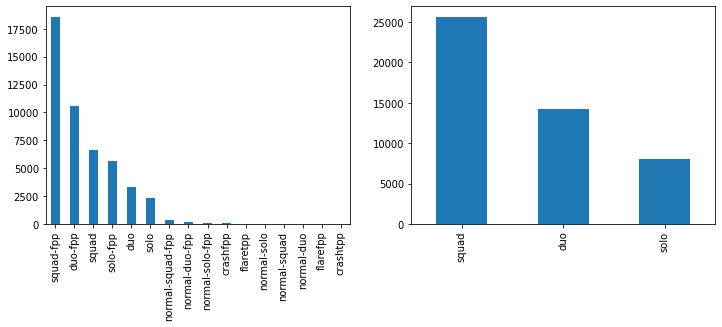

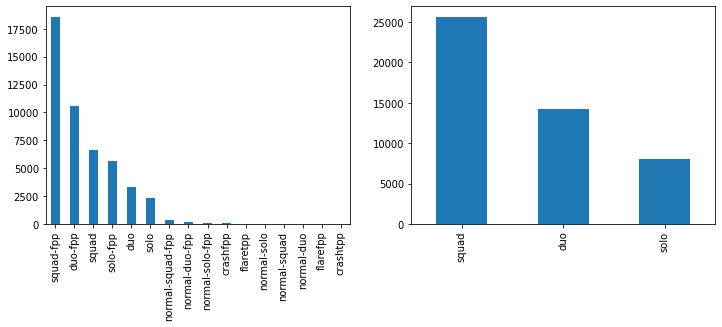

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

for more understanding on the above functions refer [fig ax](https://www.educative.io/edpresso/what-is-a-subplots-in-matplotlib) , [groupby](https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.html) , [lambda](https://www.w3schools.com/python/python_lambda.asp) , [value_counts](https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array) .

###Player Analysis
- players in match and group

During a game, 100 players join the same server,  so in the case of duos the max teams are 50 and in the case of squads the max teams are 25.


In [ ]:
def mergeList(list1,list2):
    return list(itertools.product(list1,list2))
match = train.groupby(['matchType','matchId']).size().to_frame('players in match')
group = train.groupby(['matchType','matchId','groupId']).size().to_frame('players in group')
pd.concat([match.groupby('matchType').describe()[mergeList(['players in match'],['min','mean','max'])], 
           group.groupby('matchType').describe()[mergeList(['players in group'],['min','mean','max'])]], axis=1)

players in match                   players in group                
                       min       mean    max              min      mean   max
matchType                                                                    
duo                    7.0  92.985658  100.0              1.0  2.050456  72.0
solo                   1.0  89.031872  100.0              1.0  1.039249  64.0
squad                  5.0  93.723193  100.0              1.0  3.492575  74.0

understanding  [describe](https://www.geeksforgeeks.org/python-pandas-dataframe-describe-method/) ,  [to.frame](https://www.geeksforgeeks.org/python-pandas-series-to_frame/) ,  [mergelist and itertools](https://www.onlinetutorialspoint.com/python/how-to-merge-two-lists-in-python.html)

In [ ]:
print(group['players in group'].nlargest(5))

matchType  matchId         groupId       
squad      b30f3d87189aa6  14d6b54cdec6bc    74
duo        3e029737889ce9  b8275198faa03b    72
solo       41a634f62f86b7  128b07271aa012    64
duo        7e93ce71ac6f61  7385e5fe214021    49
squad      3c2531adf5b942  e52a2e6ca30474    36
Name: players in group, dtype: int64


In [ ]:
''' ex) matchId=='3e029737889ce9', groupId=='b8275198faa03b'
'''
subset = train[train['matchId']=='3e029737889ce9']
sub_grp = subset[subset['groupId']=='b8275198faa03b']

print('matchId ==\'3e029737889ce9\' & groupId ==\'b8275198faa03b\'')
print('-'*50)
print('players:',len(subset))
print('groups:',subset['groupId'].nunique())
print('numGroups:',subset['numGroups'].unique())
print('maxPlace:',subset['maxPlace'].unique())
print('-'*50)
print('max-group players:',len(sub_grp))
print('max-group winPlacePerc:',sub_grp['winPlacePerc'].unique())
print('-'*50)
print('winPlacePerc:',subset['winPlacePerc'].sort_values().unique())

matchId =='3e029737889ce9' & groupId =='b8275198faa03b'
--------------------------------------------------
players: 99
groups: 14
numGroups: [14]
maxPlace: [50]
--------------------------------------------------
max-group players: 72
max-group winPlacePerc: [0.2449]
--------------------------------------------------
winPlacePerc: [0.     0.0204 0.0408 0.0612 0.0816 0.102  0.1224 0.1633 0.1837 0.2041
 0.2245 0.2449 0.5102 1.    ]


In [ ]:
'''another example: '''
subset = train[train['matchId']=='b30f3d87189aa6']
sub_grp = subset[subset['groupId']== '14d6b54cdec6bc']

print('matchId == b30f3d87189aa6 & groupId ==14d6b54cdec6bc')
print('-'*50)
print('players:', len(subset))
print('groups:',subset['groupId'].nunique())
print('numGROUPS:',subset['numGroups'].unique()) 
print('maxplace:',subset['maxPlace'].unique())
print('*'*50)
print('max-group players:',len(sub_grp))
print('max group winPlacePerc:',sub_grp['winPlacePerc'].unique())
print('*'*50)
print('winPlacePerc:',subset['winPlacePerc'].sort_values().unique())





matchId == b30f3d87189aa6 & groupId ==14d6b54cdec6bc
--------------------------------------------------
players: 89
groups: 2
numGROUPS: [2]
maxplace: [2]
**************************************************
max-group players: 74
max group winPlacePerc: [0.]
**************************************************
winPlacePerc: [0. 1.]


##To check **correlation feature** with the **winning percentage**

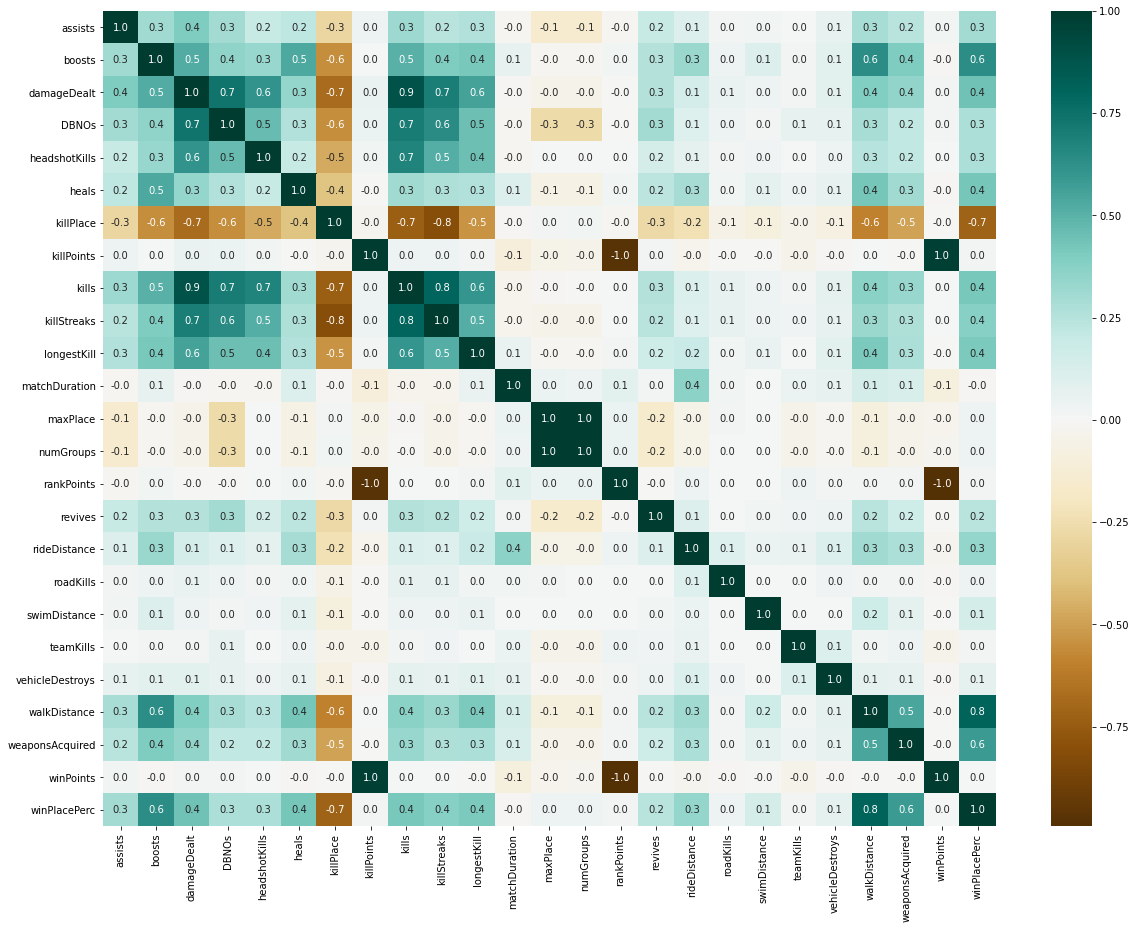

In [ ]:
corr = train.corr()
f,ax = plt.subplots(figsize=(20, 15))
sns.heatmap(train.corr(), annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

##PART 2 : **FEATURE ENGINEERING**

###*ANALYSING* THE KILLS

![](https://media.giphy.com/media/3o7WIql0K5Zk98akcU/giphy.gif)


so if you have to analyse the basic info ie, just the mean and max kills a player could possibly do, goes like this..
also refer [.4f](https://shocksolution.com/2011/11/03/python-string-format-examples/)

In [ ]:
print(" so on an average the number of kills by a person is {:.4f} players and almost 99% of the people have {} kills or less , while the maximum number of kills ever recorded by a player is {} !!!!.".format(train['kills'].mean(), train['kills'].quantile(0.99), train['kills'].max()))

 so on an average the number of kills by a person is 0.9248 players and almost 99% of the people have 7.0 kills or less , while the maximum number of kills ever recorded by a player is 72 !!!!.


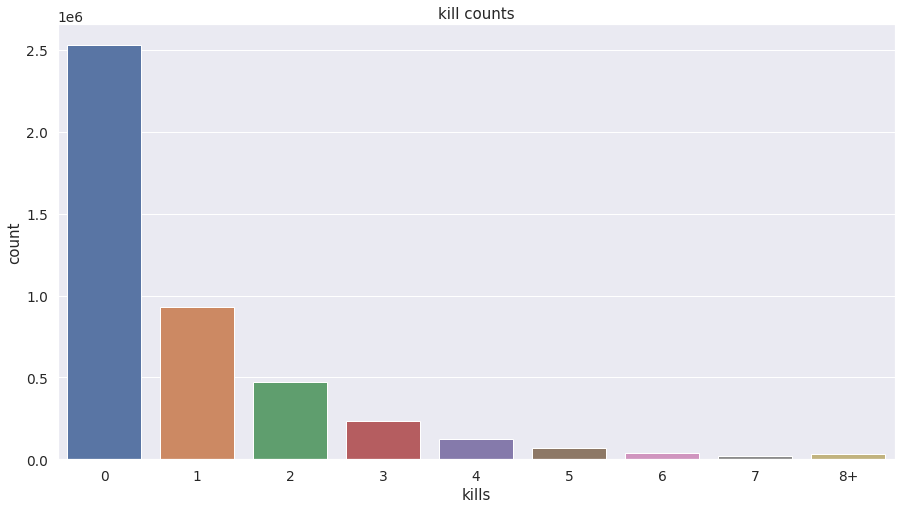

In [ ]:
data = train.copy()
data.loc[data['kills']> data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,8))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("kill counts",fontsize=15)
plt.show()

###As we can observe most of em are **unable to make a single kill** but instead **deal with some damage.** 
---
SO WHEN PLOTTED INTO BAR GRAPH:

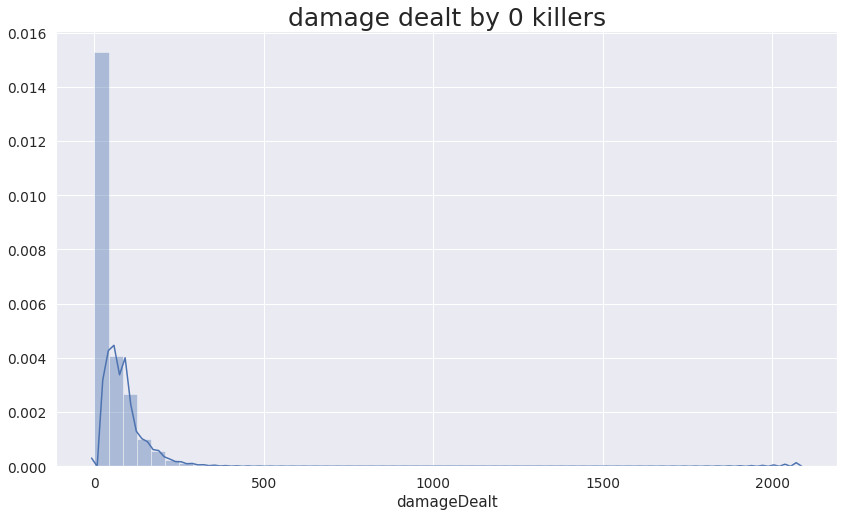

In [ ]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(14,8))
plt.title("damage dealt by 0 killers", fontsize=25)
sns.distplot(data['damageDealt'])
plt.show()


####There are also people **who win** ***without  making a single kill*** or without ***even dealing with the damage***.


In [ ]:
print("A total of {} players ({:.4f}%) have won withou t a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))
data1 = train[train['damageDealt'] == 0].copy()
print("A total of {} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

A total of 16666 players (0.3748%) have won withou t a single kill!
A total of 4770 players (0.1073%) have won without dealing damage!


###Now , how **number of killings** can effect the **winning percentage**.??

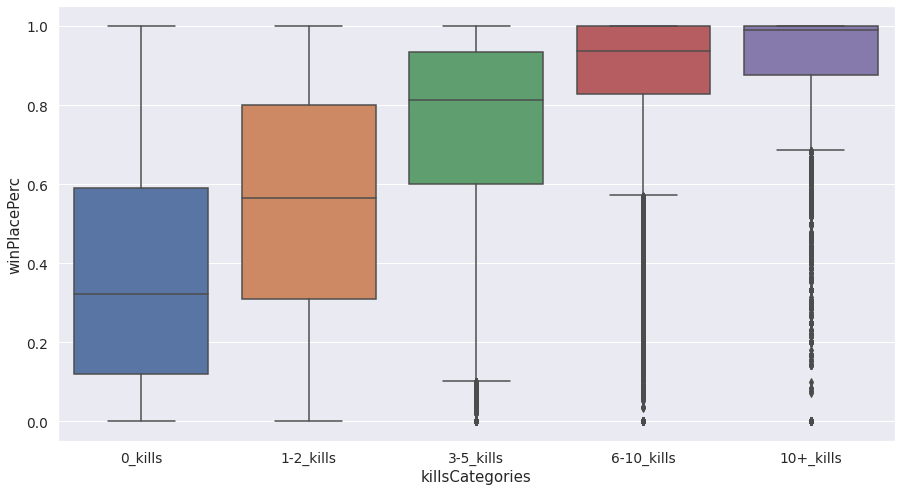

In [ ]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

***INFERENCE*** : base on the above box plot we can infer that the one with higher kills has high correlation with the winning place percentage.

###ANALYSING THE RUNNING
![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn.dribbble.com%2Fusers%2F1298729%2Fscreenshots%2F3639477%2Fbg_run_dribble.gif&f=1&nofb=1)

In [ ]:
print("{} players ( {:.4f}) walked 0 meters. This means that either they die before even entering the battlefield circle or they either C-A-M-P !!(😑)".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train)))

98054 players ( 2.0329) walked 0 meters. This means that either they die before even entering the battlefield circle or they either C-A-M-P !!(😑)


based on the above analysis we can observe that there are outliers regarding number of  kills .

* Similarly there is outliers regarding walking distances.
* but there are other various factors too, such as **RIDE DISTANCE**, **SWIM DISTANCE** , AND AS ABOVE **WALK DISTANCE**.
*But my analysis below is going to be on how the running distance is correlated to the winning percentage. 


there can also be another type of analysis where a ***player without zero movement but has contributed to reasonable number of kills*** (ie: 1 or above )can be considered as an ***outlier*** by assigning a boolean value such as 1 and can later be detected and removed.( this analysis is done in the data cleaning process under detection of fraudsters.)

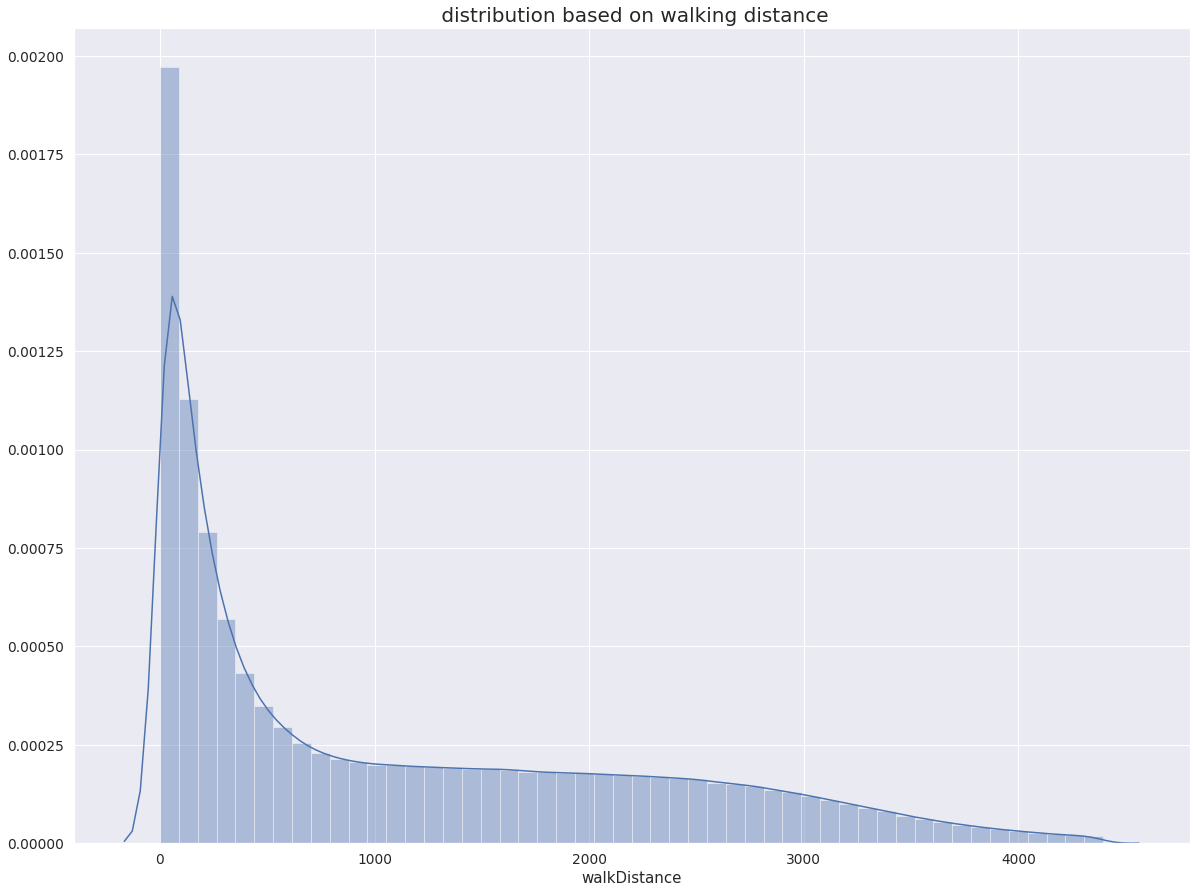

In [ ]:
data = train.copy()
data= data[data['walkDistance']< train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(20,15))
plt.title(" distribution based on walking distance",fontsize= 20)
sns.distplot(data['walkDistance'])
plt.show()


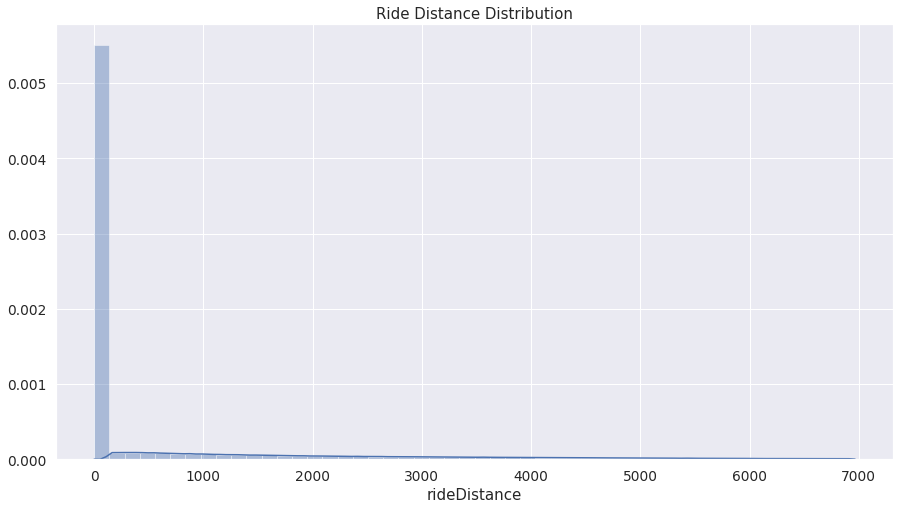

In [ ]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.99)]
plt.figure(figsize=(15,8))
plt.title("Ride Distance Distribution",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

##Analysing the effect of running on winning percentage

So the analysis is done through a ***scatter plot*** where we casn observe a **high correlation** between running and winning percentage . Maybe because the longer a players is alive, more he/she tends to move hence  possibilities of coming in contact with the enemy and acquiring kills is increased and thus the increase in chance of winning.

**Seaborn’s** ***jointplot*** displays a relationship between 2 variables (bivariate) as well as 1D profiles (univariate) in the margins. This plot is a convenience class that wraps JointGrid.

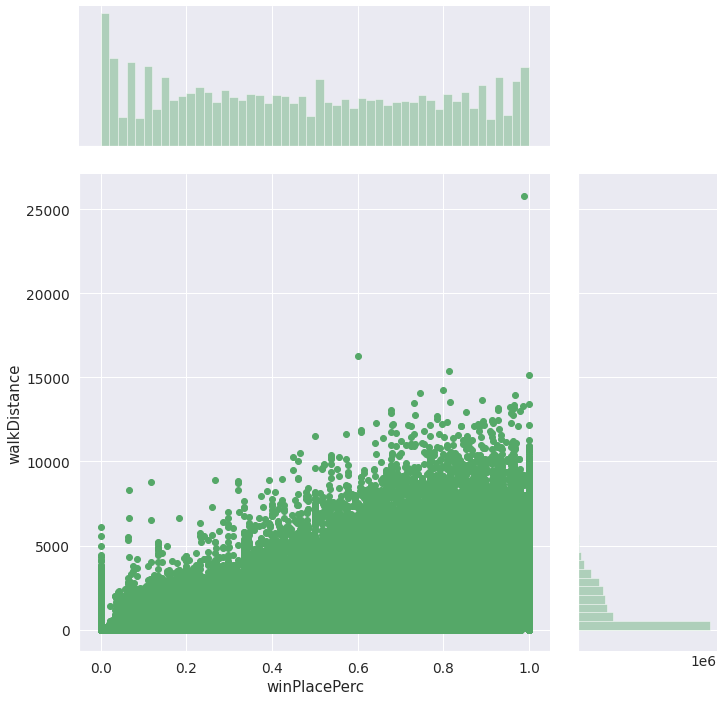

In [ ]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=10, ratio=3, color="g")
plt.show()

Therefore from the above plot we can infer that ***walking distance*** has **high correlation** with **winPlacePerc**.


##Analysis on riding

In [ ]:
print("Therefore an average person drives for {:.1f}m, 99% of people have drived {}m or less, while THE RIDER rode for {} m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

Therefore an average person drives for 606.1m, 99% of people have drived 6966.0m or less, while THE RIDER rode for 40710.0 m.


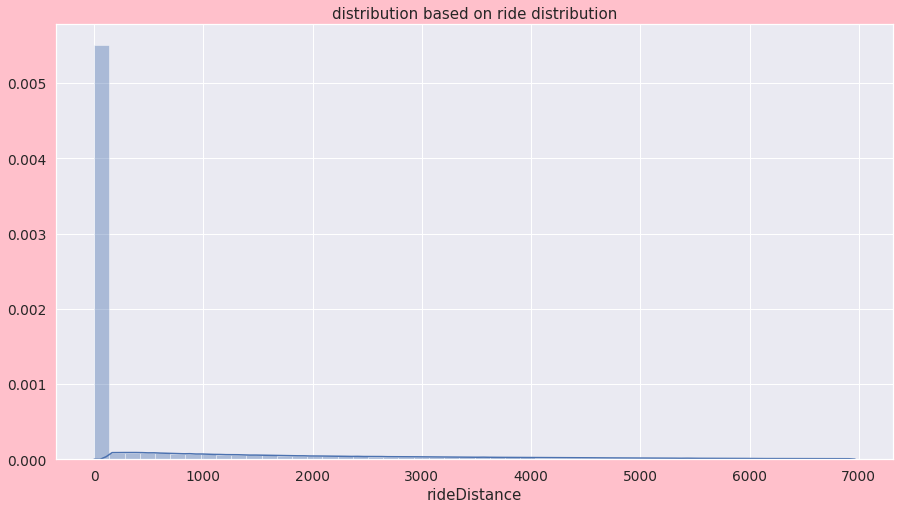

In [ ]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.99)]
plt.figure(figsize=(15,8), facecolor= "pink", )
plt.title("distribution based on ride distribution",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

In [ ]:
print(" Nearly {} ({:.4f}%) have driven zero meters. This indicates that players prefer trekking/walking over driving ." .format(len(data[data['rideDistance']==0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

 Nearly 3309429 (23.1022%) have driven zero meters. This indicates that players prefer trekking/walking over driving .


##Effect of riding on winning percentage
from the below scatter plot we shall try to derive the correlation between driving and winning.



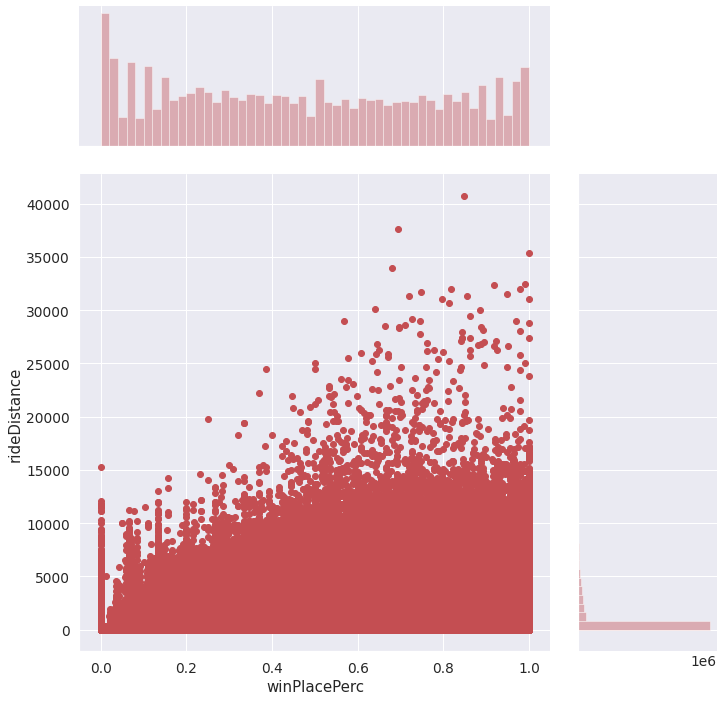

In [ ]:
sns.jointplot(x="winPlacePerc" ,y= "rideDistance", data = train , height = 10, ratio=3 , color="r")
plt.show()

if a player is skilled then he/she usually aims to destroy the vehicle(mainly vehicle tyres). now we shall try proving the statement made.

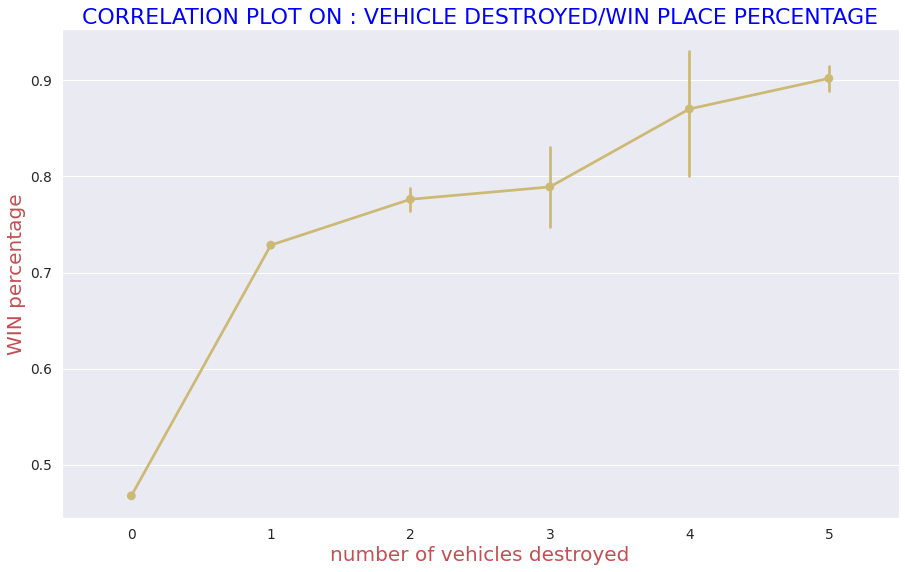

In [ ]:
f,ax = plt.subplots(figsize =(15,9))
sns.pointplot(x = 'vehicleDestroys', y= 'winPlacePerc' , data= data ,color='y' )
plt.xlabel('number of vehicles destroyed', fontsize=20, color='r')
plt.ylabel('WIN percentage',fontsize=20, color = 'r')
plt.title('CORRELATION PLOT ON : VEHICLE DESTROYED/WIN PLACE PERCENTAGE', fontsize = 22 , color='blue')
plt.show()

In [ ]:
print("on an average a player uses {:.2f} healing items, where as 99% of the players nearly use {}.".format(train['heals'].mean(), train['heals'].quantile(0.99)))
print(" also the average player uses {:.2f} boosting items , where as 99% of the players use {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99)))

on an average a player uses 1.37 healing items, where as 99% of the players nearly use 12.0.
 also the average player uses 1.11 boosting items , where as 99% of the players use 7.0.


###ANALYSING THE  **HEALING AND BOOSTING** EFFECT ON WINNING PERCENTAGE

SEPERATE PLOT FOR HEAL ITEMS USED 

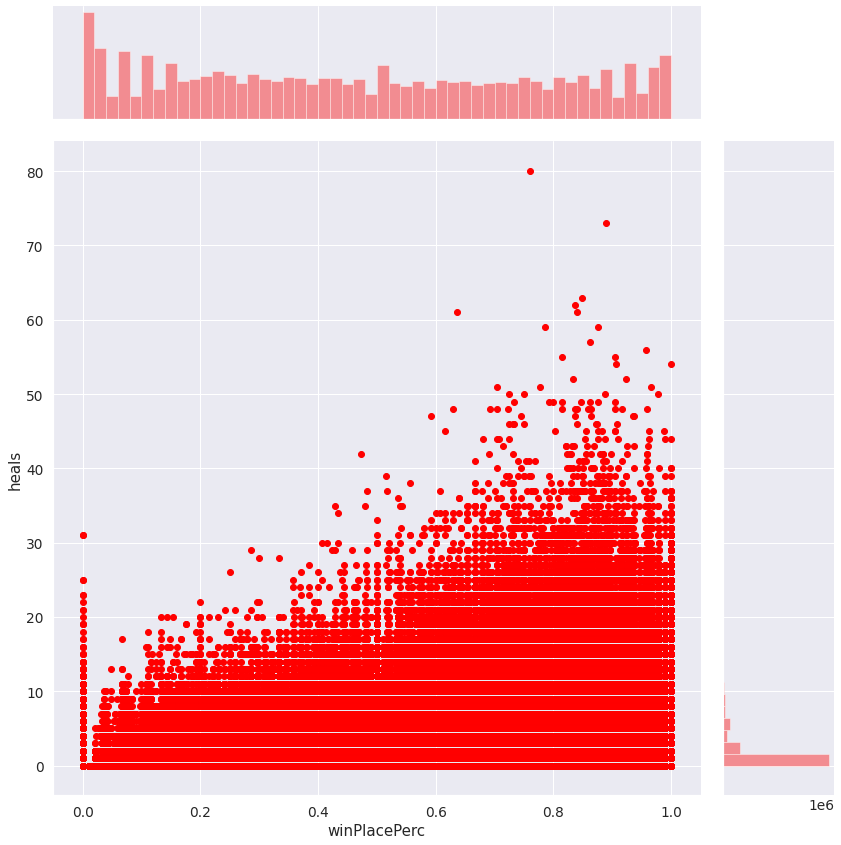

In [ ]:
sns.jointplot(x="winPlacePerc",y ="heals", data= train, height=12, color= "red")

####SEPERATE PLOT FOR **BOOSTS**

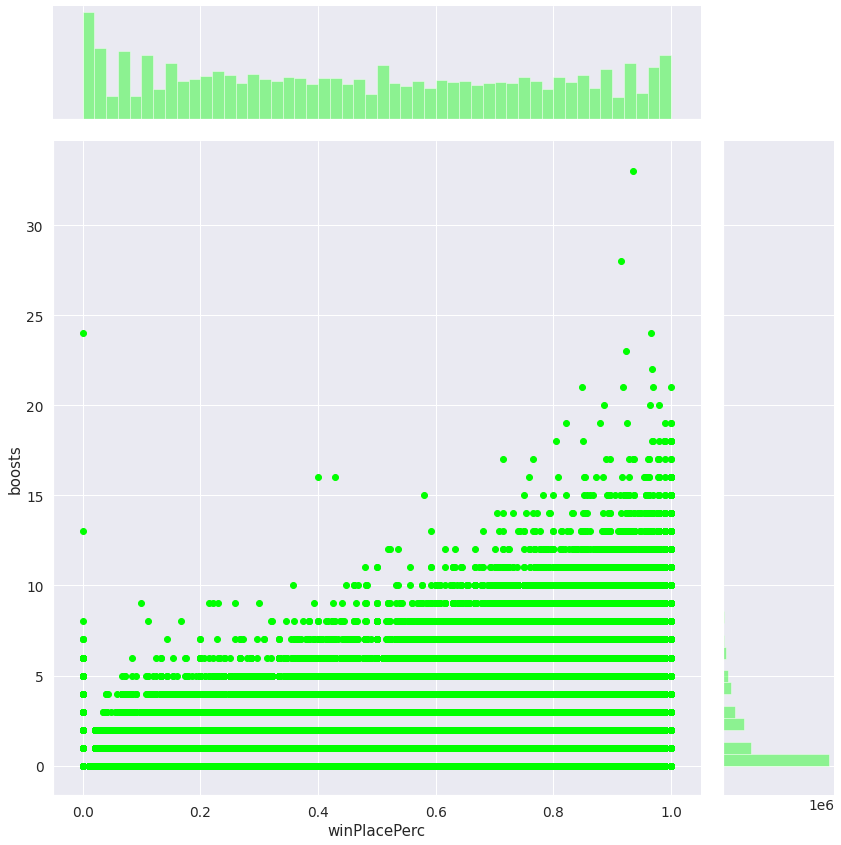

In [ ]:
sns.jointplot(x="winPlacePerc",y ="boosts", data= train, height=12, color= "lime")

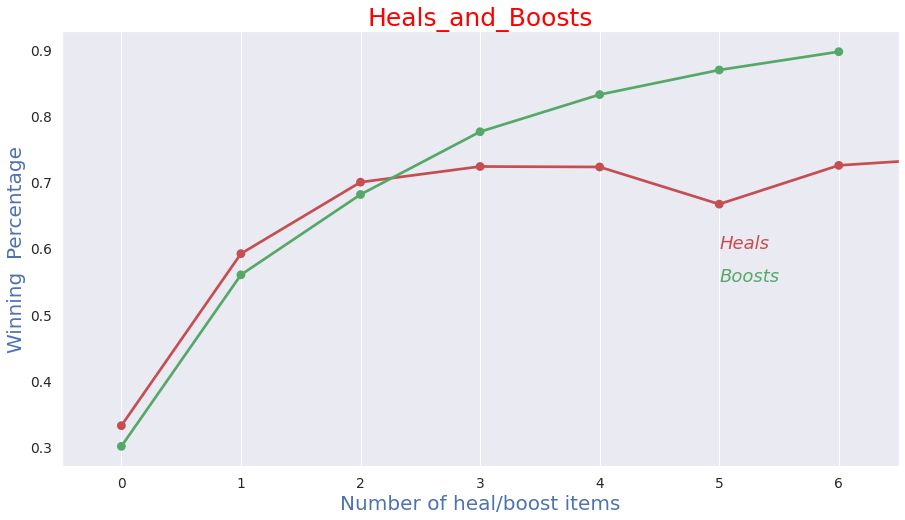

In [ ]:
data = train.copy()
data = data[data['heals']< data['heals'].quantile(0.99)]
data = data[data['boosts']< data['boosts'].quantile(0.99)]

f,ax = plt.subplots(figsize =(15,8))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='r')
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='g')
plt.text(5,0.6,'Heals',color='r',fontsize = 18 ,style = 'oblique')
plt.text(5,0.55,'Boosts',color='g',fontsize = 18 ,style = 'oblique')
plt.xlabel('Number of heal/boost items',fontsize = 20, color='b')
plt.ylabel('Winning  Percentage',fontsize = 20,color='b')
plt.title('Heals_and_Boosts',fontsize = 25,color='red')
plt.grid()
plt.show()


###So based on the above plot from (heals_and_plots) we can derive that boosts and heals have high correlation with the winning percetage. but mostly its **BOOSTS**

###Effect of killing from : solo, duos and squads on winning percentage

In [ ]:
solos = train[train['numGroups']>50]
duos = train[(train['numGroups']>25) & (train['numGroups']<= 50)] 
squads = train[train['numGroups']<= 25]
print( "{} ({:.3f}%) of the matches are usually solo, {} ({:.3f}%) are duo and {} ({:.3f}%) are squads ." .format( len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train)))


709111 (15.946%) of the matches are usually solo, 3295326 (74.103%) are duo and 442529 (9.951%) are squads .


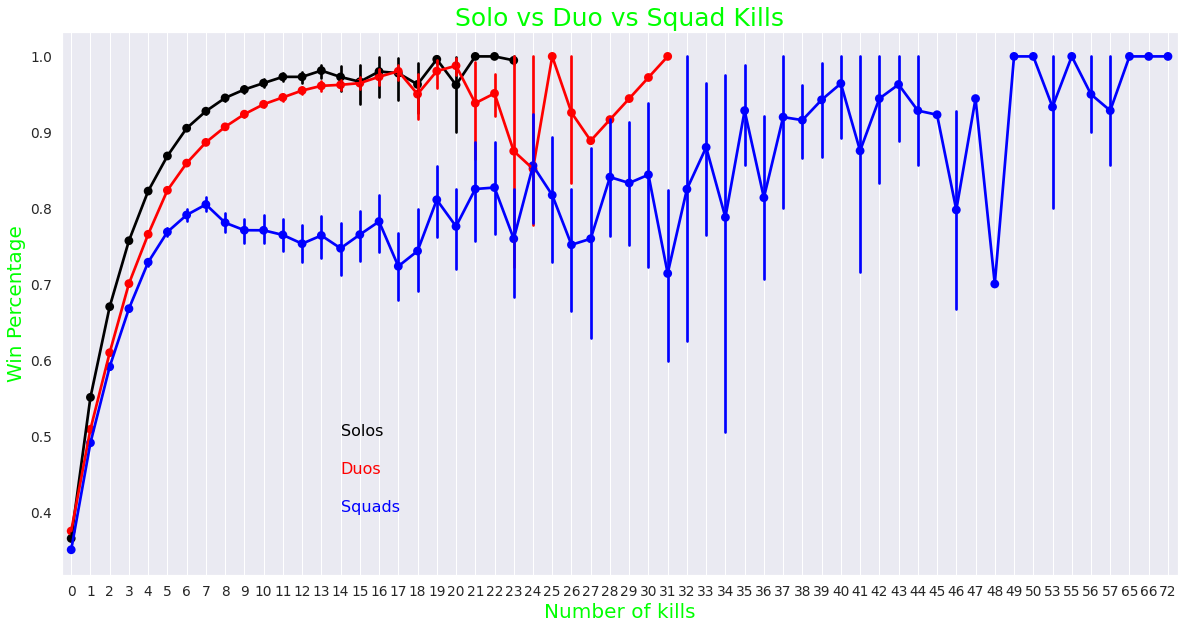

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black')
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='red')
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='blue')
plt.text(14,0.5,'Solos',color='black',fontsize = 16)
plt.text(14,0.45,'Duos',color='red',fontsize = 16)
plt.text(14,0.4,'Squads',color='blue',fontsize = 16)
plt.xlabel('Number of kills',fontsize = 20,color='lime')
plt.ylabel('Win Percentage',fontsize = 20,color='lime')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 25,color='lime')
plt.grid()
plt.show()

From the above plot we can infer that when **solos and duos** near approx 25 as the number of kills they **behave nearly similar** but squads behave differently with the same number of kills.

##HOW DOES KNOCKING OR ASSISTING OR REVIVING EFFECTS THE WINNING PERCENTAGE

###All the three attributes above mentioned happenes only in squads of duos , where a knock gives a team mate a chance to revive his team mate. assist means to have an involvement in killing the enenmy. also the attribute revive has a factor where once a teammate is knoecked and then revived and then he is knocked , his squad will have lesser number of time to revive him/her.

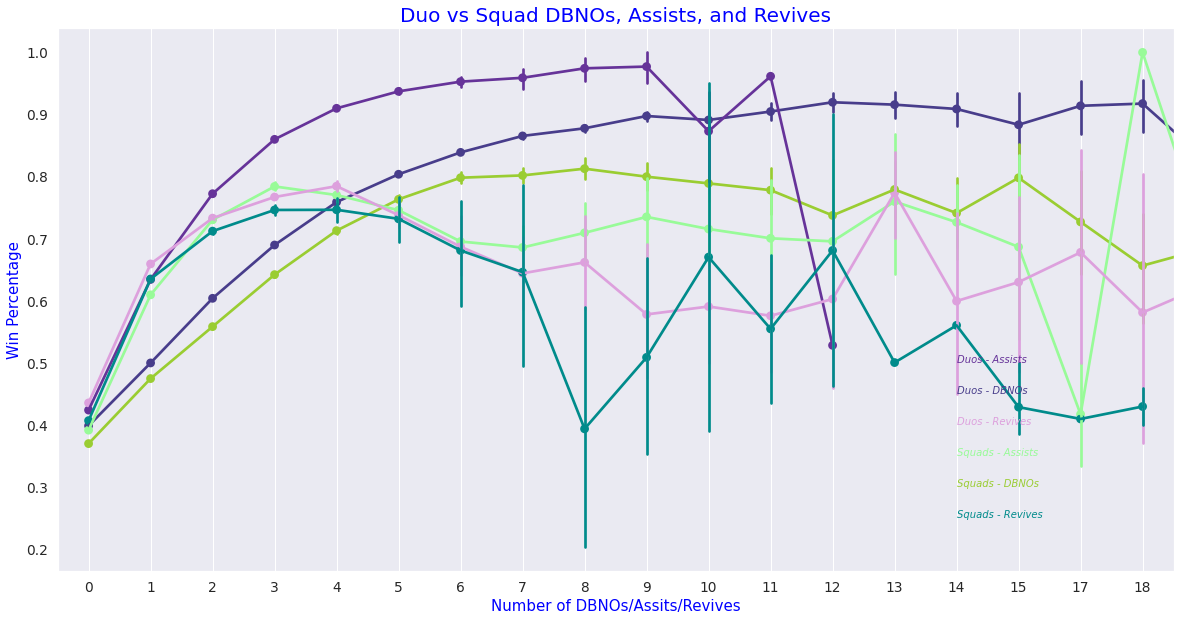

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duos,color='darkslateblue',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squads,color='yellowgreen',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=duos,color='rebeccapurple',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=squads,color='palegreen',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=duos,color='plum',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squads,color='darkcyan',alpha=0.8)
plt.text(14,0.5,'Duos - Assists',color='rebeccapurple',fontsize = 10,style = 'italic')
plt.text(14,0.45,'Duos - DBNOs',color='darkslateblue',fontsize = 10,style = 'italic')
plt.text(14,0.4,'Duos - Revives',color='plum',fontsize = 10,style = 'italic')
plt.text(14,0.35,'Squads - Assists',color='palegreen',fontsize = 10,style = 'italic')
plt.text(14,0.3,'Squads - DBNOs',color='yellowgreen',fontsize = 10,style = 'italic')
plt.text(14,0.25,'Squads - Revives',color='darkcyan',fontsize = 10,style = 'italic')
plt.xlabel('Number of DBNOs/Assits/Revives',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Duo vs Squad DBNOs, Assists, and Revives',fontsize = 20,color='blue')
plt.grid()
plt.show()

#PART 2 : DATA CLEANING 

###REMOVAL OF OUTLIERS AND FINDING THE FRAUDSTERS


So there are a few factors which determine the fraudsters such as:

* SPEED : moving to one side to different side of the map in few seconds
* AIM   : when they take control of players aim 
* RECOIL: they dont have to manage the recoil , all they have to do is press the fire button .
* WALLS : allowing the fraudsters to see through the walls .

In [ ]:
#looking for NAN value under the column WinPlacePerc
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


winPlacePerc should have either 1 or 0 but not NaN

In [ ]:
train.drop(train[train['winPlacePerc'].isnull()].index, inplace=True)

[panda.dataframe.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html?highlight=drop)        ..to remove the specified columns or rows


*   also the code below is to see the number or rows and colums / dimensionality of the data set after removing the Nan row



In [ ]:
train.shape

(4446965, 29)

##ANOMALIES IN KILLING
KILL hacks where the player can have automated bots which allows players to bind a key or mouse button to an auto aim and lock on function that will automatically target any ememy in line of sight. If you are playing duo or in a group, group members will not trigger this function. A trigger bot can then be set to automatically shoot for you or you can chose to shoot yourself.


> now we are about to calculate  **totalDistance** travelled by a player which is the sum total of **rideDistance, walkDistance and swimDistance**

> We should add a new feature which is "_totalDistance" consisting on ride , walk and swim distance.













In [ ]:
train['_totalaDistance'] = train['swimDistance'] + train['rideDistance']  + train['walkDistance']

Create a new feature ***'headshot_rate'.*** We notice that the most players score in the 0 to 10% region. But there are a few anomalies that have a headshot_rate of 100% percent with more than 9 kills!